# TFOD Transfer Learning


Here we will use the Tensorflow Object Detection API for training a pre-trained SSD-RetinaNet model with our duck toy dataset. We will use the feature extractor layers and the bounding box regression layers from the SSD RetinaNet model and add our own classification layers with it. We will then train these classification layers to get our Object Detection Model.

In [32]:
import os
import io
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
from six  import BytesIO

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

These utilities will be later used for Preparing dataset and for visualizing the output

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [6]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

## Dataset Preprocessing

### Visualize data

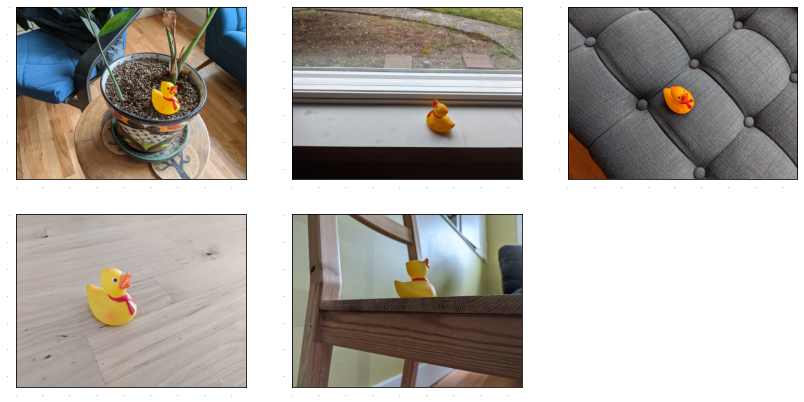

In [17]:
train_image_dir = 'dataset/ducky/train'
train_images_np = []
for i in range(1, 6):
    image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

### Generate Ground Truth Bounding Boxes

In [18]:
gt_boxes = [
    np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
    np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
    np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
    np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
    np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

### Prep Data for Training

The id 0 is reserved for background, so every object to be detected have to use id from 1. To achieve this we use the variable `label_id_offset`. The `label_id_offset` here shifts all classes by a certain number of indices. We have to convert the class labels to one-hot encoding. And then we need to convert everything to tensors. We do this here so that the model receives one-hot labels where non-background classes start counting at the zeroth index, i.e. we remove the 0th column from the one-hot encoding as all images have atleast 1 object and no image has just the background.

In [19]:
duck_class_id = 1
num_classes = 1

category_index = {
    duck_class_id: {
        'id': duck_class_id, 
        'name': 'rubber_ducky'
    }
}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    # convert image to tensor and store it in a list
    tensor_image = tf.convert_to_tensor(train_image_np, dtype=tf.float32)
    train_image_tensors.append(tf.expand_dims(tensor_image, axis=0))
    
    # convert the bounding box data into tensors and store it in a list
    tensor_bounding_box = tf.convert_to_tensor(gt_box_np, dtype=tf.float32)
    gt_box_tensors.append(tensor_bounding_box)
    
    # remove the 0th column so that the 0th column now correspond to 1st label
    shifted_labels = np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(shifted_labels)
    one_hot_encoded_labels = tf.one_hot(zero_indexed_groundtruth_classes, num_classes)
    gt_classes_one_hot_tensors.append(one_hot_encoded_labels)

print('Done prepping data.')

Done prepping data.


### Visualizing data with boxes

Here we will give a temporary score of 1 to all the boxes and use `plot_detections` utility, so that the images with the ground truth boxes are shown

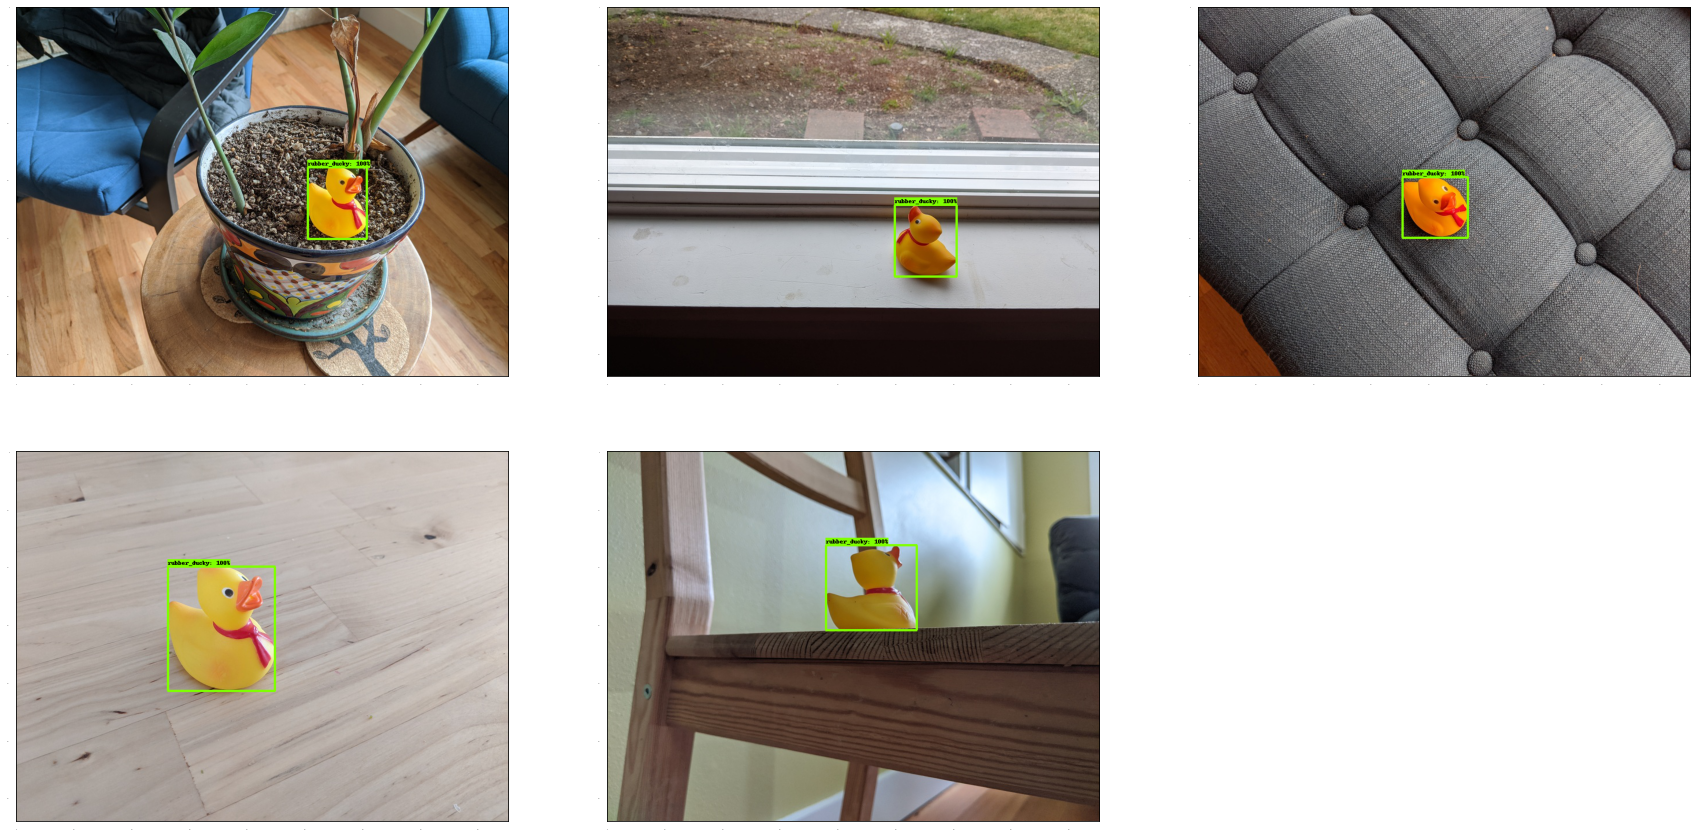

In [20]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Model Preping

### Download the Model Weights

In [21]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2021-02-05 11:17:48--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.203.144, 2404:6800:4009:820::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.203.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  16.8MB/s    in 15s     

2021-02-05 11:18:03 (15.6 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



### Load the weigths into the model instance

Here we will do the following:

- Copy the model's config pipeline from tfod-models/research/object-detection/configs/tf2/`<model-name>`.config into the working directory 

- Since we are working off of a COCO architecture which predicts 90 class slots by default, we override the `num_classes` field here to be just one (for our new rubber ducky class).


- **Set up object-based checkpoint restore**: RetinaNet has two prediction `heads`
    - one for classification, 
    - the other for box regression.  
    We will restore the box regression head but initialize the classification head from scratch (we show the omission below by commenting out the line that we would add if we wanted to restore both heads).  We will use some temporary variables to load the different layers from the SSD_RESNET model so that these variables can be later used to create our own model.
    **Note**:These layers contains weights taken from checkpoint-0.
    
- Lastly we will run model through a dummy image(Image with just 0 value as pixels) so that variables needed by the model are properly created.


In [25]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load the mdoel config from pipeline config file
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True


# Build the model from the updated config file
detection_model = model_builder.build(model_config=model_config, is_training=True)


# load the checkpoints into this empty model that we built above
# We start with creating a structure for what all layer weights we want to load/restor
# as we only want the feature extractor and box prediction layers
# we first create a box prediction layer checkpoint sturcture
fake_box_predictor = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
# then we add the feature extractor to the structure to get a new structure
fake_model = tf.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.train.Checkpoint(model=fake_model)
# we now load the checkpoints present in a location given by the variable checkpoint_path
ckpt.restore(checkpoint_path).expect_partial()


#This is the last step to set all the variables of the model up before we do actual fine-tuning
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


## Fine Tuning(Training) the model

- set the required parameters like batch_size, leaarning_rate etc.
- collect the layer's name that we want to train/fine-tune
- define a custom training loop for Forward and Backward pass that will:
    - take input image
    - perform prediction
    - calculate the loss
    - during backpropagation will update the layers picked for fine tuning

### Defining the Params

In [26]:
batch_size = 4
learning_rate = 0.01
num_batches = 100

### Collecting layers for Fine Tuning

In [27]:
tf.keras.backend.set_learning_phase(True)

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

/home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


### Defining Custom Training Loop

Custom training loop will have the following in a loop(here the loop determines the epochs):
**Note: make sure that the calculations are performed inside the GradientTape scope**
- Foward Pass
    - Should call the model's preprocessing function passing the input batch
    - Should call the model's predict function passing the tensor inputs
    
    **Note: The input should be tensors and not a list of tensors: so use tf.concat() on list to convert it into tensor**
    - Should collect the output from the model's predict function
- Backward Pass
    - Provide ground truth using the model's preovide_ground_truth function
    - Calculate the loss using the model's loss function
    - Backpropagate the losses to the layers which we want to fine tune

In [33]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(groundtruth_boxes_list=groundtruth_boxes_list, groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = [detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors]
            preprocessed_images = tf.concat(preprocessed_images, axis=0)
            
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

In [35]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # for implementing image augmentation, we can add the part here
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.186085
batch 10 of 100, loss=0.16291334
batch 20 of 100, loss=0.06064497
batch 30 of 100, loss=0.032463044
batch 40 of 100, loss=0.0065454617
batch 50 of 100, loss=0.004380832
batch 60 of 100, loss=0.0031347428
batch 70 of 100, loss=0.0021504548
batch 80 of 100, loss=0.00226725
batch 90 of 100, loss=0.0020125047
Done fine-tuning!


## Testing the model

In [36]:
# uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

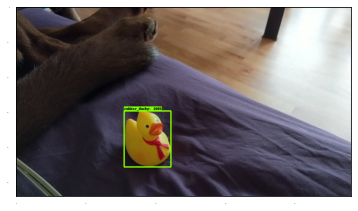

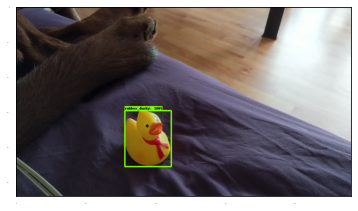

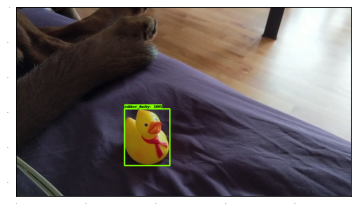

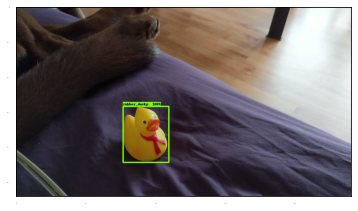

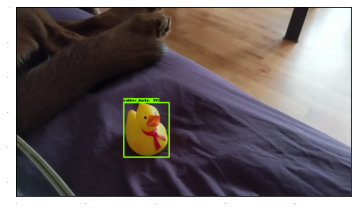

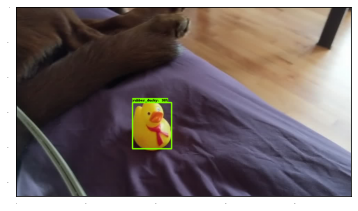

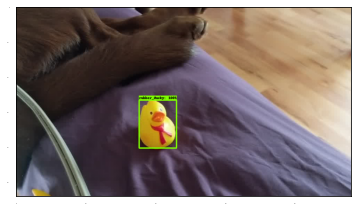

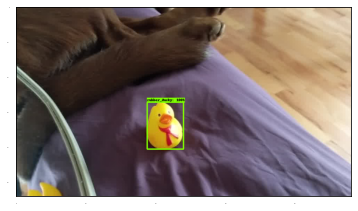

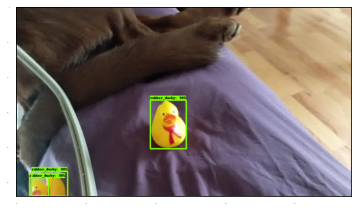

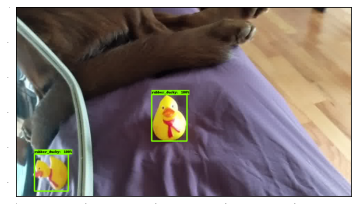

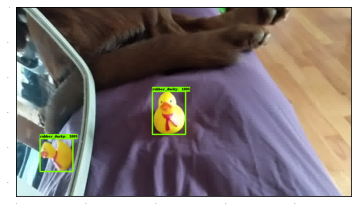

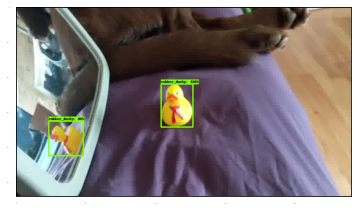

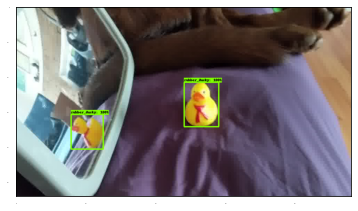

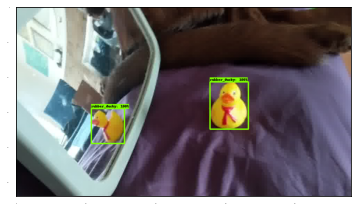

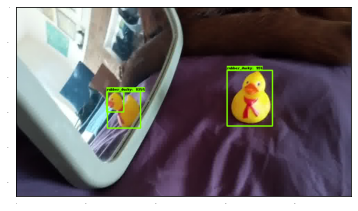

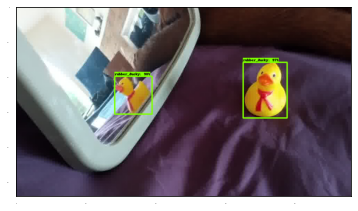

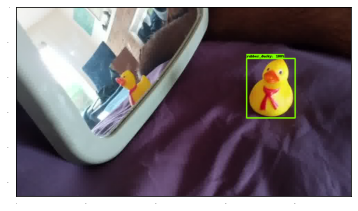

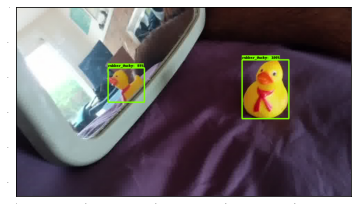

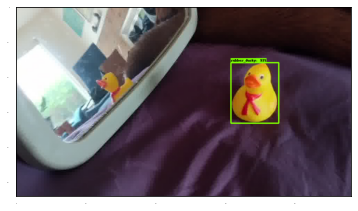

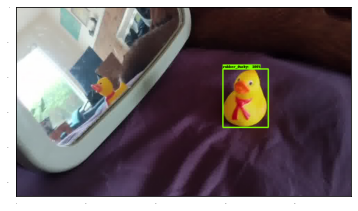

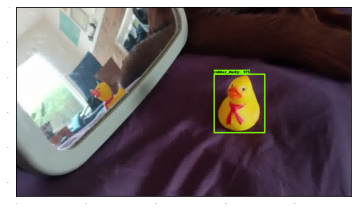

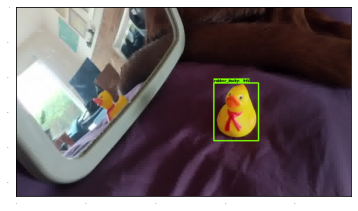

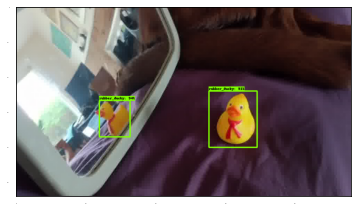

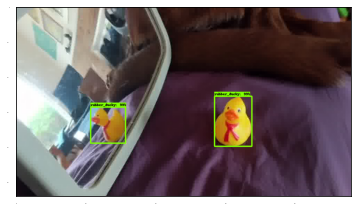

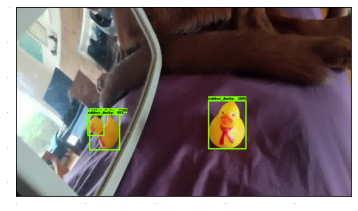

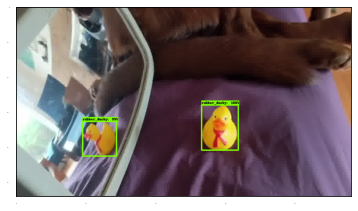

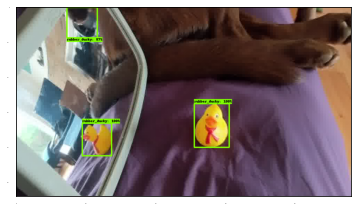

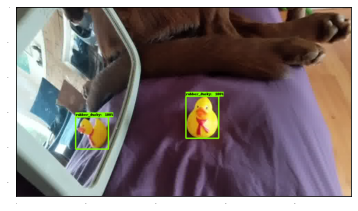

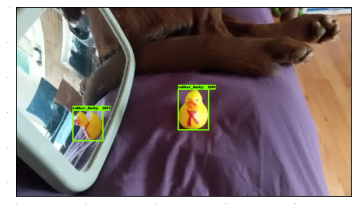

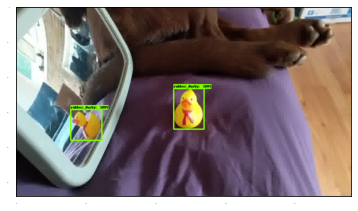

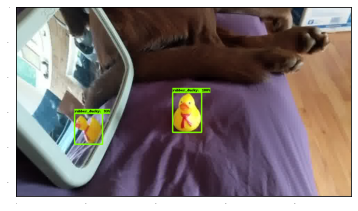

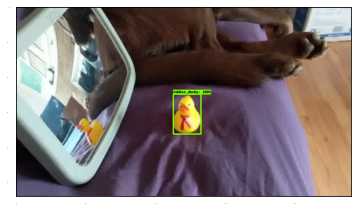

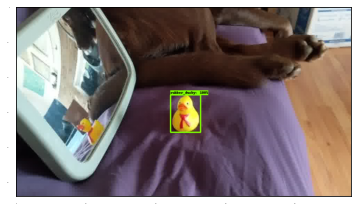

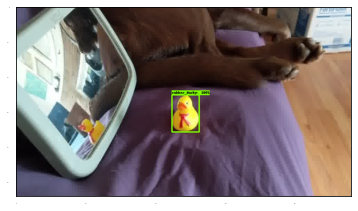

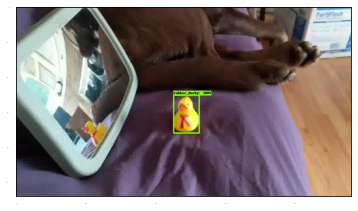

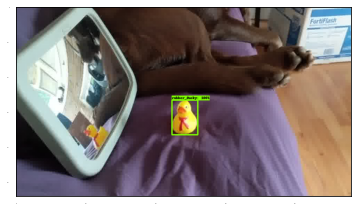

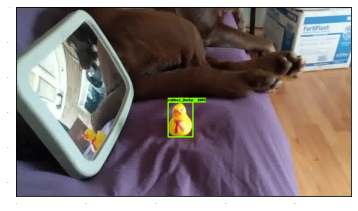

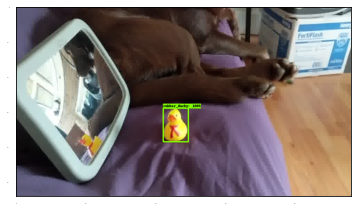

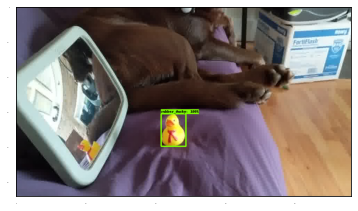

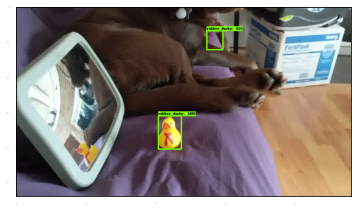

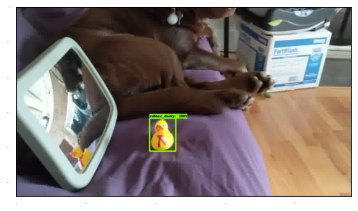

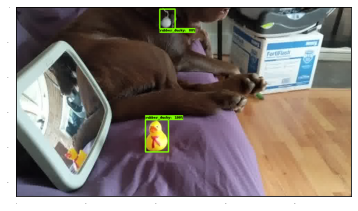

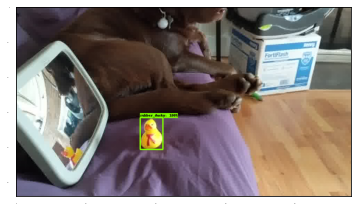

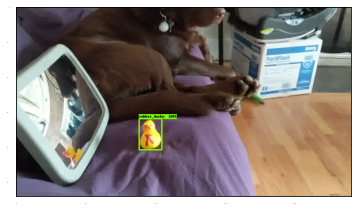

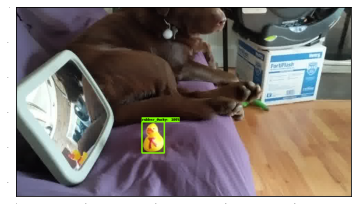

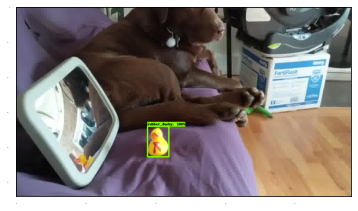

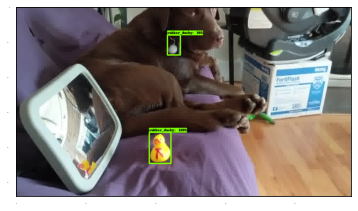

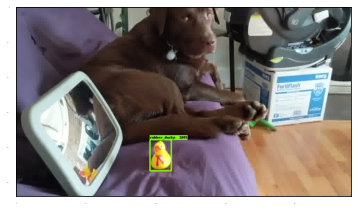

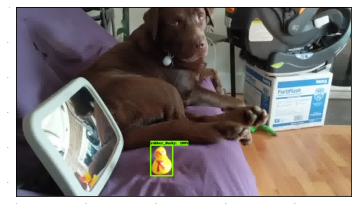

In [39]:
test_image_dir = 'dataset/ducky/test/'
test_images_np = []
for i in range(1, 50):
    image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)+ label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index,
        figsize=(15, 20),
    )
    plt.show()